In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
df=pd.read_csv('BAJFINANCE.csv')
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BAJAUTOFIN,EQ,46.95,49.45,50.75,46.50,50.75,50.75,50.05,7600,3.803800e+10,NaN,NaN,NaN
1,2000-01-04,BAJAUTOFIN,EQ,50.75,53.20,53.20,47.90,48.00,48.10,48.56,5000,2.428000e+10,NaN,NaN,NaN
2,2000-01-05,BAJAUTOFIN,EQ,48.10,46.55,47.40,44.60,44.60,44.60,45.47,3500,1.591450e+10,NaN,NaN,NaN
3,2000-01-06,BAJAUTOFIN,EQ,44.60,43.50,46.00,42.10,46.00,45.25,44.43,6200,2.754750e+10,NaN,NaN,NaN
4,2000-01-07,BAJAUTOFIN,EQ,45.25,48.00,48.00,42.00,42.90,42.90,44.44,3500,1.555550e+10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,2020-08-25,BAJFINANCE,EQ,3492.05,3525.00,3660.00,3510.00,3658.00,3642.90,3579.12,9854070,3.526895e+15,339815.0,1498309.0,0.1520
5066,2020-08-26,BAJFINANCE,EQ,3642.90,3665.00,3707.00,3631.00,3638.20,3645.55,3668.17,6665336,2.444958e+15,213994.0,944373.0,0.1417
5067,2020-08-27,BAJFINANCE,EQ,3645.55,3656.95,3668.40,3596.40,3636.00,3632.50,3631.13,4611132,1.674361e+15,162374.0,387513.0,0.0840
5068,2020-08-28,BAJFINANCE,EQ,3632.50,3650.00,3688.00,3617.05,3672.05,3670.80,3652.77,4251575,1.553003e+15,137033.0,434147.0,0.1021


In [3]:
df.set_index('Date',inplace=True)

<Axes: xlabel='Date'>

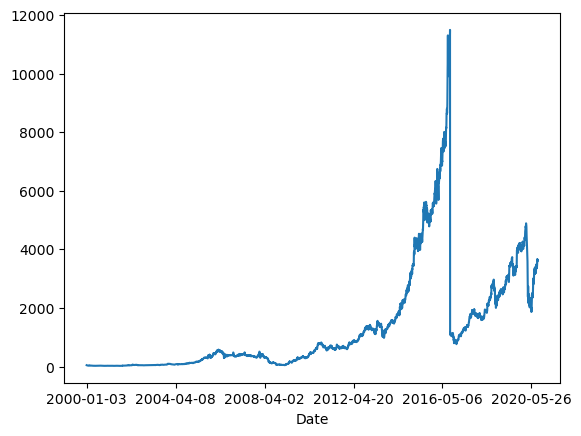

In [4]:
# plotting target variable over time
df['VWAP'].plot()

# Preprocessing

In [5]:
# Initial (rows,columns)
df.shape

(5070, 14)

In [6]:
# missing values
df.isna().sum()

Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2779
Deliverable Volume     446
%Deliverble            446
dtype: int64

In [7]:
# Delete rows with missing values
df.dropna(inplace=True)

In [8]:
# Confirm no values are missing
df.isna().sum()

Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Trades                0
Deliverable Volume    0
%Deliverble           0
dtype: int64

In [9]:
# Updated (rows,columns)
df.shape

(2291, 14)

In [10]:
lag_features=['High','Low','Volume','Turnover','Trades']

In [12]:
for feature in lag_features:
    df[feature+'rolling_mean_3']=df[feature].rolling(window=3).mean()
    df[feature+'rolling_mean_7']=df[feature].rolling(window=7).mean()

In [13]:
for feature in lag_features:
    df[feature+'rolling_std_3']=df[feature].rolling(window=3).std()
    df[feature+'rolling_std_7']=df[feature].rolling(window=7).std()

In [14]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,Highrolling_std_3,Highrolling_std_7,Lowrolling_std_3,Lowrolling_std_7,Volumerolling_std_3,Volumerolling_std_7,Turnoverrolling_std_3,Turnoverrolling_std_7,Tradesrolling_std_3,Tradesrolling_std_7
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-01,BAJFINANCE,EQ,616.70,617.00,636.50,616.00,627.00,631.85,627.01,6894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-02,BAJFINANCE,EQ,631.85,625.00,638.90,620.00,634.00,633.45,636.04,2769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-03,BAJFINANCE,EQ,633.45,625.15,637.80,620.00,623.00,625.00,625.09,51427,...,1.201388,NaN,2.309401,NaN,2.698087e+04,NaN,1.685217e+12,NaN,670.500559,NaN
2011-06-06,BAJFINANCE,EQ,625.00,620.00,641.00,611.35,611.35,614.00,616.03,5446,...,1.625833,NaN,4.994080,NaN,2.735270e+04,NaN,1.710136e+12,NaN,148.769396,NaN
2011-06-07,BAJFINANCE,EQ,614.00,604.00,623.95,604.00,619.90,619.15,617.73,5991,...,9.062422,NaN,8.008797,NaN,2.639122e+04,NaN,1.652377e+12,NaN,78.270897,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-25,BAJFINANCE,EQ,3492.05,3525.00,3660.00,3510.00,3658.00,3642.90,3579.12,9854070,...,111.840660,89.327396,69.777271,61.471880,3.613401e+06,2.348888e+06,1.315344e+15,8.608028e+14,125273.490429,81831.863468
2020-08-26,BAJFINANCE,EQ,3642.90,3665.00,3707.00,3631.00,3638.20,3645.55,3668.17,6665336,...,100.081633,116.819954,115.027609,100.638138,1.987080e+06,2.403611e+06,7.237865e+14,8.886997e+14,74234.798338,82982.637290
2020-08-27,BAJFINANCE,EQ,3645.55,3656.95,3668.40,3596.40,3636.00,3632.50,3631.13,4611132,...,25.064982,122.216500,62.320569,111.614377,2.641848e+06,2.408580e+06,9.306171e+14,8.850381e+14,91269.616085,82597.470913


In [15]:
# Updated (rows,columns)
df.shape

(2291, 34)

In [16]:
# new missing values
df.isna().sum()

Symbol                    0
Series                    0
Prev Close                0
Open                      0
High                      0
Low                       0
Last                      0
Close                     0
VWAP                      0
Volume                    0
Turnover                  0
Trades                    0
Deliverable Volume        0
%Deliverble               0
Highrolling_mean_3        2
Highrolling_mean_7        6
Lowrolling_mean_3         2
Lowrolling_mean_7         6
Volumerolling_mean_3      2
Volumerolling_mean_7      6
Turnoverrolling_mean_3    2
Turnoverrolling_mean_7    6
Tradesrolling_mean_3      2
Tradesrolling_mean_7      6
Highrolling_std_3         2
Highrolling_std_7         6
Lowrolling_std_3          2
Lowrolling_std_7          6
Volumerolling_std_3       2
Volumerolling_std_7       6
Turnoverrolling_std_3     2
Turnoverrolling_std_7     6
Tradesrolling_std_3       2
Tradesrolling_std_7       6
dtype: int64

In [17]:
# Delete rows with new missing values
df.dropna(inplace=True)

In [18]:
# Confirm no new values are missing
df.isna().sum()

Symbol                    0
Series                    0
Prev Close                0
Open                      0
High                      0
Low                       0
Last                      0
Close                     0
VWAP                      0
Volume                    0
Turnover                  0
Trades                    0
Deliverable Volume        0
%Deliverble               0
Highrolling_mean_3        0
Highrolling_mean_7        0
Lowrolling_mean_3         0
Lowrolling_mean_7         0
Volumerolling_mean_3      0
Volumerolling_mean_7      0
Turnoverrolling_mean_3    0
Turnoverrolling_mean_7    0
Tradesrolling_mean_3      0
Tradesrolling_mean_7      0
Highrolling_std_3         0
Highrolling_std_7         0
Lowrolling_std_3          0
Lowrolling_std_7          0
Volumerolling_std_3       0
Volumerolling_std_7       0
Turnoverrolling_std_3     0
Turnoverrolling_std_7     0
Tradesrolling_std_3       0
Tradesrolling_std_7       0
dtype: int64

In [19]:
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'Highrolling_mean_3', 'Highrolling_mean_7',
       'Lowrolling_mean_3', 'Lowrolling_mean_7', 'Volumerolling_mean_3',
       'Volumerolling_mean_7', 'Turnoverrolling_mean_3',
       'Turnoverrolling_mean_7', 'Tradesrolling_mean_3',
       'Tradesrolling_mean_7', 'Highrolling_std_3', 'Highrolling_std_7',
       'Lowrolling_std_3', 'Lowrolling_std_7', 'Volumerolling_std_3',
       'Volumerolling_std_7', 'Turnoverrolling_std_3', 'Turnoverrolling_std_7',
       'Tradesrolling_std_3', 'Tradesrolling_std_7'],
      dtype='object')

In [20]:
ind_features=['Highrolling_mean_3', 'Highrolling_mean_7',
       'Lowrolling_mean_3', 'Lowrolling_mean_7', 'Volumerolling_mean_3',
       'Volumerolling_mean_7', 'Turnoverrolling_mean_3',
       'Turnoverrolling_mean_7', 'Tradesrolling_mean_3',
       'Tradesrolling_mean_7', 'Highrolling_std_3', 'Highrolling_std_7',
       'Lowrolling_std_3', 'Lowrolling_std_7', 'Volumerolling_std_3',
       'Volumerolling_std_7', 'Turnoverrolling_std_3', 'Turnoverrolling_std_7',
       'Tradesrolling_std_3', 'Tradesrolling_std_7']

In [21]:
training_data=df[0:1800]
test_data=df[1800:]
training_data

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,Highrolling_std_3,Highrolling_std_7,Lowrolling_std_3,Lowrolling_std_7,Volumerolling_std_3,Volumerolling_std_7,Turnoverrolling_std_3,Turnoverrolling_std_7,Tradesrolling_std_3,Tradesrolling_std_7
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-09,BAJFINANCE,EQ,635.60,639.80,647.00,630.00,630.00,631.10,638.27,31252,...,12.769789,7.494911,15.011107,9.410145,13497.047986,18373.894011,8.665128e+11,1.155773e+12,354.841279,463.942320
2011-06-10,BAJFINANCE,EQ,631.10,641.85,648.25,618.55,621.10,622.20,634.16,30885,...,1.639360,8.227994,13.030765,9.501961,2434.970705,18047.331029,1.579562e+11,1.136003e+12,272.875429,448.020620
2011-06-13,BAJFINANCE,EQ,622.20,616.00,627.85,616.00,622.75,624.95,622.92,3981,...,11.434196,9.497080,7.456597,9.298317,15640.051929,17835.642665,9.982094e+11,1.123423e+12,557.373603,464.778596
2011-06-14,BAJFINANCE,EQ,624.95,625.00,628.95,619.95,621.20,622.10,625.35,5597,...,11.473593,10.198891,2.002707,9.293713,15088.183102,13139.472184,9.595224e+11,8.397765e+11,656.385050,455.234163
2011-06-15,BAJFINANCE,EQ,622.10,612.00,623.00,598.10,605.00,601.70,606.90,12590,...,3.165833,11.352292,11.643560,11.262712,4575.812970,12469.137006,2.733211e+11,7.983186e+11,150.639747,436.941971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-04,BAJFINANCE,EQ,2724.05,2724.00,2777.65,2683.50,2748.00,2746.30,2726.23,2606992,...,88.954937,79.489416,83.341306,107.041856,696998.737787,642979.884199,1.827289e+14,1.673270e+14,2794.744413,21708.856675
2018-09-05,BAJFINANCE,EQ,2746.30,2740.15,2764.80,2668.00,2704.45,2716.90,2712.53,1728455,...,63.129081,100.594924,24.113551,119.854378,483305.554092,570427.041296,1.375623e+14,1.467744e+14,21770.352164,17267.163548
2018-09-06,BAJFINANCE,EQ,2716.90,2729.00,2731.50,2671.40,2672.20,2684.10,2695.89,1147879,...,23.818183,113.135709,8.146779,118.187686,734609.476628,584307.816124,2.020435e+14,1.561692e+14,30923.312263,24013.596897


In [23]:
model=auto_arima(y=training_data['VWAP'],exogenous=training_data[ind_features],trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20931.522, Time=5.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20925.214, Time=1.49 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20926.337, Time=1.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20926.309, Time=4.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32616.913, Time=1.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20929.224, Time=4.52 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 19.221 seconds


In [24]:
model.fit(training_data['VWAP'],training_data[ind_features])

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [25]:
forecast=model.predict(n_periods=len(test_data), exogenous=test_data[ind_features])

In [26]:
test_data['Forecast_ARIMA']=forecast

<Axes: xlabel='Date'>

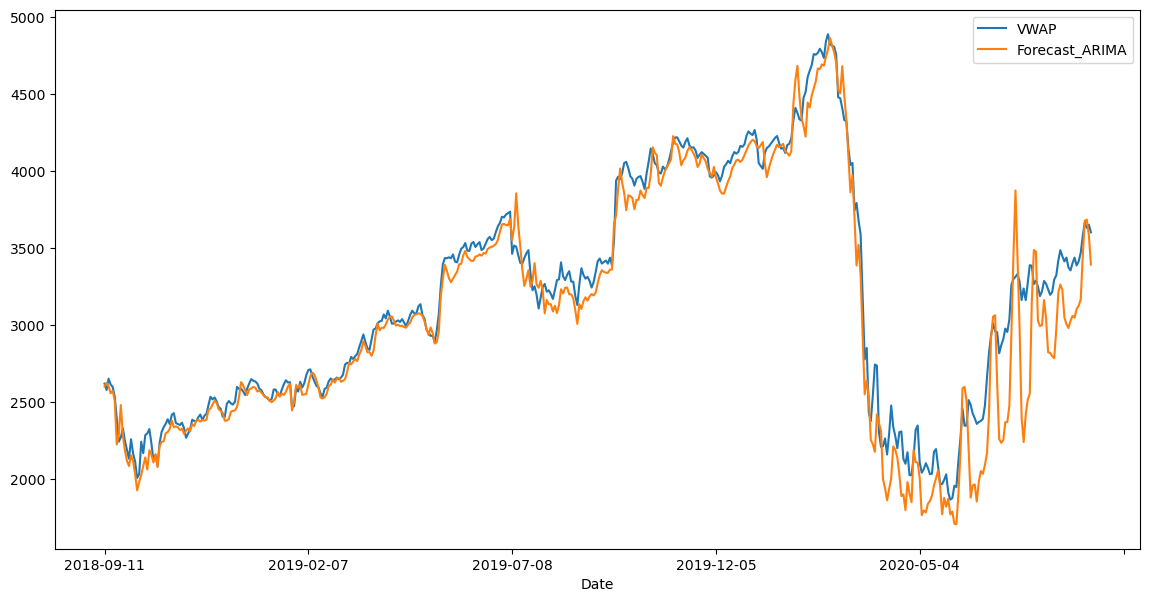

In [27]:
# The Auto ARIMA model appears to be relatively close in predicting the stock price
test_data[['VWAP','Forecast_ARIMA']].plot(figsize=(14,7))

# Model Accuracy Metrics

In [29]:
mse = np.sqrt(mean_squared_error(test_data['VWAP'],test_data['Forecast_ARIMA']))
mae = mean_absolute_error(test_data['VWAP'],test_data['Forecast_ARIMA'])

In [31]:
print('Mean Square Error: $%.2f' % mse)
print('Mean Absolute Error: $%.2f' % mae)

Mean Square Error: 187.75
Mean Absolute Error: 124.64
